In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sys
sys.path.append('/Documents/FAIR-200/fair/')

from fair import *

cc_tuning_fairpaper = pd.read_csv(("CMIP6_cc_full.csv")) # cc_full
therm_tuning_fairpaper = pd.read_csv(("CMIP6_climresp.csv")) # _climresp
therm_tuning_fairpaper_f = pd.read_csv(("CMIP6_f_params.csv")) #f_params

from scipy.optimize import minimize as min_calc
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'fair'

In [2]:
tas_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/tas_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
conc_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)

Text(0.5, 0, 'years')

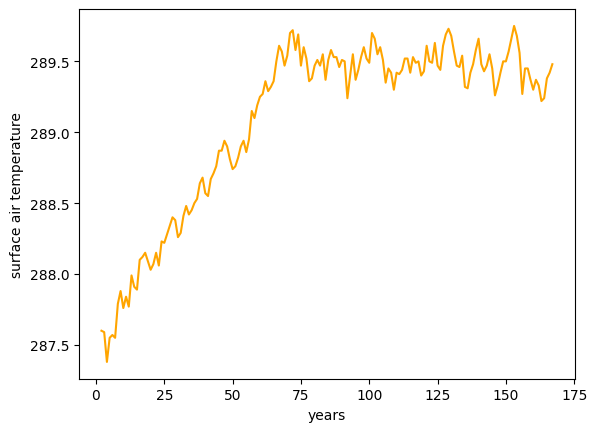

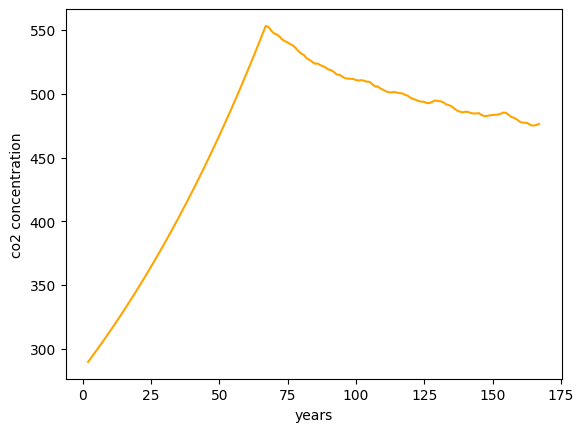

In [3]:
plt.plot(tas_access_1000.index.values, tas_access_1000.values, color='orange')
plt.ylabel("surface air temperature")
plt.xlabel("years")

plt.figure()

plt.plot(conc_access_1000.index.values, conc_access_1000.values, color='orange')
plt.ylabel("co2 concentration")
plt.xlabel("years")

In [4]:
def invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc):

   g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1)
   g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 )

   diagnosed_emissions = np.zeros(C.size)
   alpha = np.zeros(C.size)
   G_A = (np.array([np.mean(C[i:i+2]) for i in np.arange(C.size)])-PI_conc)/emis2conc
   G_A[-1]=2*G_A[-1]-G_A[-2]

   alpha[0] = calculate_alpha(G=0,G_A=0,T=0,r=r,g0=g0,g1=g1)
   diagnosed_emissions[0],R = unstep_concentration(R_old=0,G_A=G_A[0],alpha=alpha[0,np.newaxis],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc)
   for t in np.arange(1,C.size):
       G = np.sum(diagnosed_emissions)
       alpha[t] = calculate_alpha(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)
       diagnosed_emissions[t],R = unstep_concentration(R_old=R,G_A=G_A[t],alpha=alpha[t,np.newaxis],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc)

   return pd.Series(index=np.arange(C.size),data=diagnosed_emissions)

Ocean carbon flux

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_76293/2491719974.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)


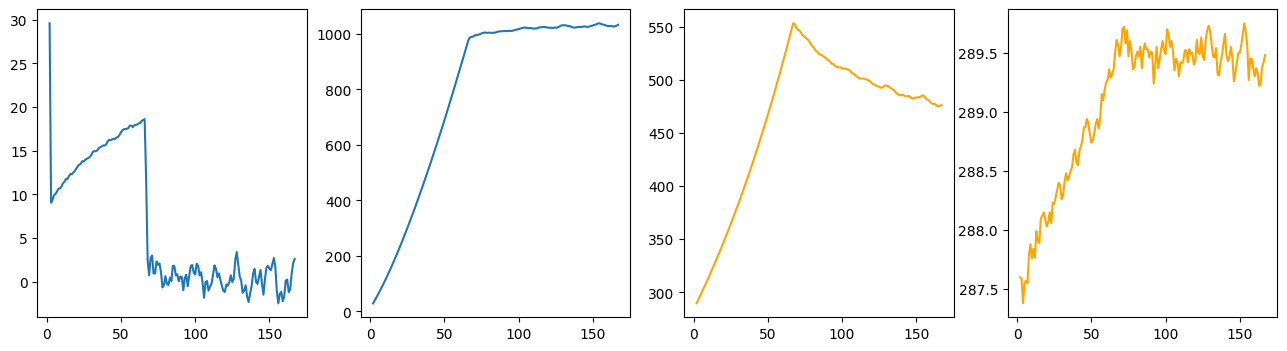

In [5]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

gas_params = get_gas_parameter_defaults(choose_gases=['carbon_dioxide'])

gas_params.loc[:,('default','carbon_dioxide')].a1 -= 0.1
gas_params.loc[:,('default','carbon_dioxide')].a2 -= 0.1
gas_params.loc[:,('default','carbon_dioxide')].a3 += 0.1
gas_params.loc[:,('default','carbon_dioxide')].a4 += 0.1

a = gas_params.iloc[:4].values.squeeze()
tau = gas_params.iloc[4:8].values.squeeze()
r = gas_params.iloc[8:12].values.squeeze()
pi_conc = gas_params.iloc[12].values.squeeze()
emis2conc = gas_params.iloc[13].values.squeeze()

r[0] = cc_tuning_fairpaper['ACCESS-ESM1-5'][0]
r[1] = cc_tuning_fairpaper['ACCESS-ESM1-5'][1]
r[2] = cc_tuning_fairpaper['ACCESS-ESM1-5'][2]
r[3] = cc_tuning_fairpaper['ACCESS-ESM1-5'][3]

onepc_ems = invert_carbon_cycle_prescribed_T(conc_access_1000.values,tas_access_1000.values-np.mean(tas_access_1000.values[0:5]),a,tau,r,pi_conc,emis2conc)
ax[0].plot(conc_access_1000.index.values, onepc_ems)
ax[1].plot(conc_access_1000.index.values, np.cumsum(onepc_ems))

ax[2].plot(conc_access_1000.index.values, conc_access_1000.values, color='orange')
ax[3].plot(tas_access_1000.index.values, tas_access_1000.values, color='orange')

In [6]:
nbp_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/nbp_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
fgco2_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 3 and 167...


/opt/anaconda3/envs/fairv200_install/lib/python3.11/site-packages/fair/fair_runner.py:127: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_76293/3216124346.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8.329600e+00  1.074208e+01  9.977040e+00  1.060076e+01  1.187324e+01
  9.678200e+00  9.570680e+00  1.040564e+01  1.104936e+01  1.210308e+01
  1.192680e+01  1.307052e+01  1.413424e+01  1.208920e+01  1.293292e+01
  1.433788e+01  1.537036e+01  1.460656e+01  1.462904e+01  1.505400e+01
  1.660896e+01  1.399268e+01  1.499764e+01  1.506136e+01  1.466632e+01
  1.532004e+01  1.556624e+01  1.634996e+01  1.637492e+

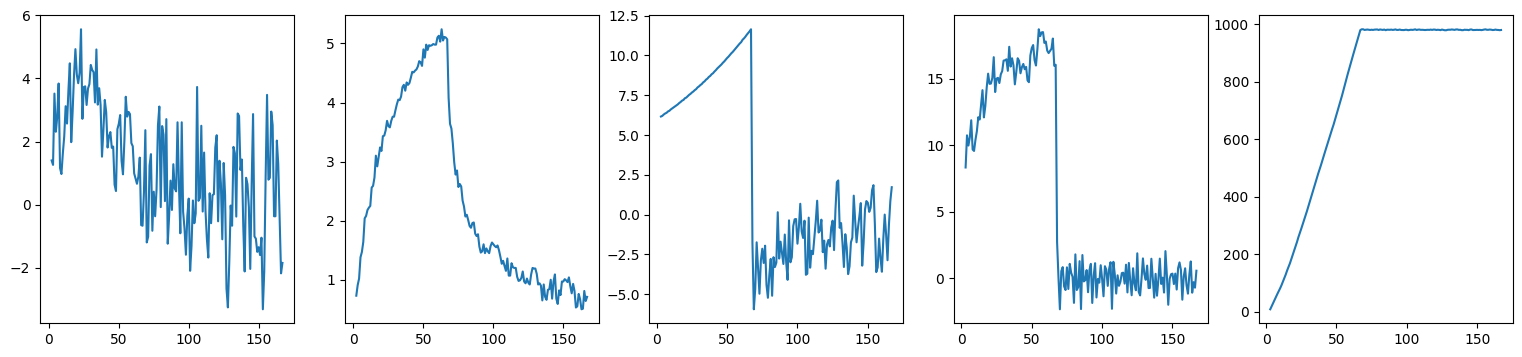

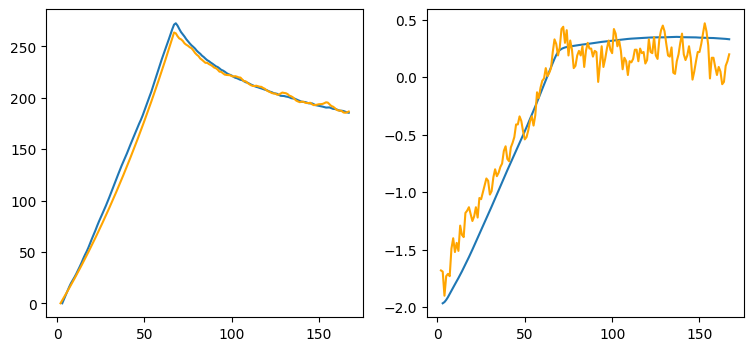

In [7]:
G_atm_cum = (conc_access_1000.values - conc_access_1000.values[0])*2.124
G_atm = (G_atm_cum - np.roll(G_atm_cum,1))[1:]

E_FF = G_atm + fgco2_access_1000.values[1:] + nbp_access_1000.values[1:] #emissions = atmospheric burden + surface downward flux between ocean and atm + net downward flux due to biosphere processes

fig, ax = plt.subplots(1,5,figsize=(19,4))
fig2, ax2 = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(nbp_access_1000.index.values, nbp_access_1000.values)
ax[1].plot(fgco2_access_1000.index.values, fgco2_access_1000.values)
ax[2].plot(conc_access_1000.index.values[1:], G_atm)
ax[3].plot(conc_access_1000.index.values[1:], E_FF)
ax[4].plot(conc_access_1000.index.values[1:], np.cumsum(E_FF))

ems = return_empty_emissions(start_year=conc_access_1000.index.values[1], end_year=conc_access_1000.index.values[-1], gases_in=['carbon_dioxide'])
ems.loc[:,(0,'carbon_dioxide')] = E_FF

gas_params.loc[:,('default','carbon_dioxide')].PI_conc = conc_access_1000.values[0]
gas_params.loc[:,('default','carbon_dioxide')].r0 = cc_tuning_fairpaper['ACCESS-ESM1-5'][0]
gas_params.loc[:,('default','carbon_dioxide')].rC = cc_tuning_fairpaper['ACCESS-ESM1-5'][1]
gas_params.loc[:,('default','carbon_dioxide')].rT = cc_tuning_fairpaper['ACCESS-ESM1-5'][2]
gas_params.loc[:,('default','carbon_dioxide')].rA = cc_tuning_fairpaper['ACCESS-ESM1-5'][3]

therm_params = get_thermal_parameter_defaults()
therm_params.loc[:,('default',1)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][0]
therm_params.loc[:,('default',2)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][1]
therm_params.loc[:,('default',3)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][2]

therm_params.loc[:,('default',1)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][0]
therm_params.loc[:,('default',2)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][1]
therm_params.loc[:,('default',3)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][2]

out_forwards = run_FaIR(emissions_in=ems, gas_parameters=gas_params, thermal_parameters=therm_params)

ax2[0].plot(out_forwards['C'] - out_forwards['C'].values[0])
ax2[1].plot(out_forwards['T'] - np.mean(out_forwards['T'].values[1911-1851-9:1911-1851+10]))

ax2[0].plot(conc_access_1000.index.values, conc_access_1000.values - conc_access_1000.values[0], color='orange')
ax2[1].plot(tas_access_1000.index.values, tas_access_1000.values - np.mean(tas_access_1000.values[1911-1851-9:1911-1851+10]), color='orange')

a = gas_params.loc[:,('default','carbon_dioxide')].values[:4]
tau = gas_params.loc[:,('default','carbon_dioxide')].values[4:8]
pi_conc = gas_params.loc[:,('default','carbon_dioxide')].PI_conc
emis2conc = gas_params.loc[:,('default','carbon_dioxide')].emis2conc
r0 = gas_params.loc[:,('default','carbon_dioxide')].values[8:12]

ems_to_aim_for = np.zeros(E_FF.size + 1)
ems_to_aim_for[1:] = E_FF[:,0]
ems_to_aim_for[0] = E_FF[0,0]

def cc_tuning_func(x,C,T,ems_to_aim_for,a,r0,tau,pi_conc,emis2conc):
    
    r = np.zeros_like(r0)
    r[0] = r0[0]*x[0]
    r[1] = r0[1]*x[1]#*x[1]
    r[2] = r0[2]*x[2]#*x[1]
    r[3] = 0.0#r0[3]*x[0]*x[2]
    
    out_ems = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,pi_conc,emis2conc)
    
    return np.sum(np.abs(out_ems - ems_to_aim_for)**2)

args_to_input = (conc_access_1000.values, tas_access_1000.values - tas_access_1000.values[0], ems_to_aim_for, a, tau, r0, pi_conc, emis2conc)

test_run = min_calc(cc_tuning_func, x0=[1,1,1], args=args_to_input)

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_76293/2491719974.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)


[0.73897101 2.00967941 0.25571629]
[27.1487203   0.07024549  0.77652137  0.        ]


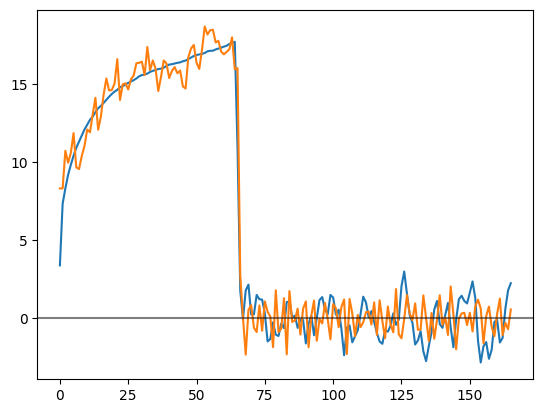

In [8]:
# C,T,r0,a,tau,pi_conc,emis2conc

def only_leave_params_to_be_set(x, alpha, beta, gamma):
    r = np.zeros_like(r0)
    r[0] = r0[0]*alpha
    r[1] = r0[1]*beta#alpha*beta
    r[2] = r0[2]*gamma#alpha*beta
    r[3] = 0.0#r0[3]*alpha*gamma
    
    ems_returned = invert_carbon_cycle_prescribed_T(x[0],x[1],a,tau,r,pi_conc,emis2conc).values
#     ems_returned[69:] = 0.0
    return ems_returned

x = [conc_access_1000.values, (tas_access_1000.values - tas_access_1000.values[0])]

test, test2 = curve_fit(only_leave_params_to_be_set, x, ems_to_aim_for)

r = np.zeros_like(r0)
r[0] = r0[0]*test[0]
r[1] = r0[1]*test[1]#*test[1]
r[2] = r0[2]*test[2]#*test[1]
r[3] = 0.0#r0[3]*test[0]*test[2]
    
plt.plot(only_leave_params_to_be_set(x, test[0], test[1], test[2]))
plt.plot(ems_to_aim_for)
plt.axhline(y=0, color='black', alpha=0.5)

print(test)
print(r)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1851 and 2016...


/opt/anaconda3/envs/fairv200_install/lib/python3.11/site-packages/fair/fair_runner.py:127: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_76293/2491719974.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_76293/2208092948.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.40070208  7.3372684   8.332702

-0.0018543626453154255 -0.00023149984344017705


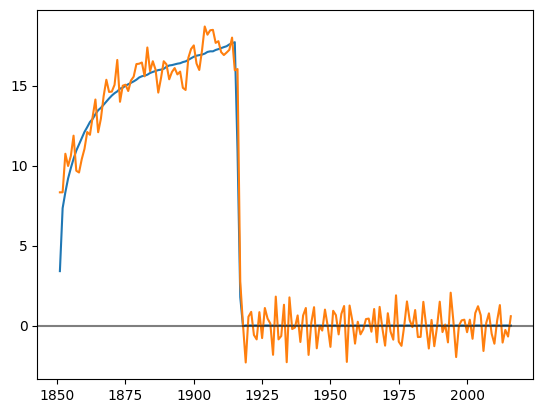

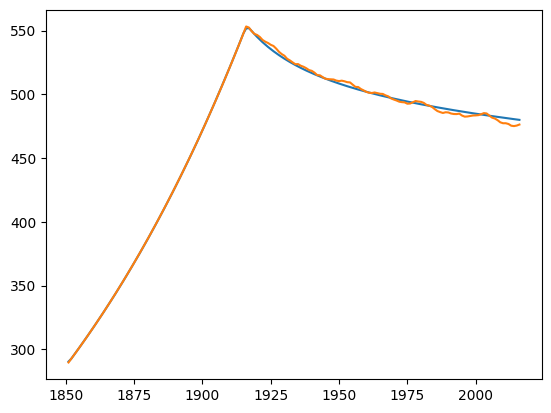

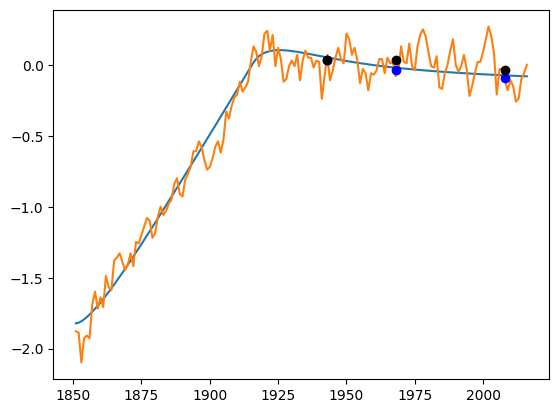

In [9]:
ems_to_rerun = return_empty_emissions(start_year=1851, end_year=ems_to_aim_for.size+1850, gases_in=['carbon_dioxide'])
ems_to_rerun.loc[:,(0,'carbon_dioxide')] = only_leave_params_to_be_set(x, test[0], test[1], test[2])
ems_to_rerun.loc[1919:,(0,'carbon_dioxide')] = 0.0

plt.plot(ems_to_rerun)
plt.plot(ems_to_rerun.index.values, ems_to_aim_for)

plt.axhline(y=0, color='black', alpha=0.5)

gas_params.loc[:,('default','carbon_dioxide')].r0 = r[0]
gas_params.loc[:,('default','carbon_dioxide')].rC = r[1]
gas_params.loc[:,('default','carbon_dioxide')].rT = r[2]
gas_params.loc[:,('default','carbon_dioxide')].rA = r[3]

gas_params.loc[:,('default','carbon_dioxide')].f1 = therm_tuning_fairpaper_f['ACCESS-ESM1-5'][0] # 3.35/np.log(2)
gas_params.loc[:,('default','carbon_dioxide')].f2 = therm_tuning_fairpaper_f['ACCESS-ESM1-5'][1]
gas_params.loc[:,('default','carbon_dioxide')].f3 = therm_tuning_fairpaper_f['ACCESS-ESM1-5'][2]

TCR = 1.99 # 1.9
ECS = 2.9 # 3.9
F_2x = 3.35 # 2.9
therm_test = get_thermal_parameter_defaults(TCR=TCR, RWF=TCR/ECS, F_2x=F_2x)
# therm_test.loc[:,('default',1)].d = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].d1.values[0]
# therm_test.loc[:,('default',2)].d = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].d2.values[0]
# therm_test.loc[:,('default',3)].d = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].d3.values[0]

# therm_test.loc[:,('default',1)].q = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].q1.values[0]
# therm_test.loc[:,('default',2)].q = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].q2.values[0]
# therm_test.loc[:,('default',3)].q = therm_tuning_fairpaper[therm_tuning_fairpaper.Model == 'ACCESS-ESM1-5'].q3.values[0]

out_test = run_FaIR(emissions_in=ems_to_rerun, gas_parameters=gas_params, thermal_parameters=therm_test)

plt.figure()
plt.plot(out_test['C'])
plt.plot(out_test['C'].index.values, conc_access_1000)

plt.figure()
plt.plot(out_test['T'] - np.mean(out_test['T'].values[1918-1851-10:1918-1851+10]))
plt.plot(out_test['C'].index.values, tas_access_1000 - np.mean(tas_access_1000.values[1918-1850-10:1918-1850+10]))

plt.scatter(1918+25, np.mean(out_test['T'].values[1918+25-1850-10:1918+25-1850+10]) - np.mean(out_test['T'].values[1918-1850-10:1918-1850+10]), color='blue', zorder=2)
plt.scatter(1918+50, np.mean(out_test['T'].values[1918+50-1850-10:1918+50-1850+10]) - np.mean(out_test['T'].values[1918-1850-10:1918-1850+10]), color='blue', zorder=2)
plt.scatter(1918+90, np.mean(out_test['T'].values[1918+90-1850-10:1918+90-1850+10]) - np.mean(out_test['T'].values[1918-1850-10:1918-1850+10]), color='blue', zorder=2)

plt.scatter(1918+25, np.mean(tas_access_1000.values[1918+25-1850-10:1918+25-1850+10]) - np.mean(tas_access_1000.values[1918-1850-10:1918-1850+10]), color='black', zorder=2)
plt.scatter(1918+50, np.mean(tas_access_1000.values[1918+50-1850-10:1918+50-1850+10]) - np.mean(tas_access_1000.values[1918-1850-10:1918-1850+10]), color='black', zorder=2)
plt.scatter(1918+90, np.mean(tas_access_1000.values[1918+90-1850-10:1918+90-1850+10]) - np.mean(tas_access_1000.values[1918-1850-10:1918-1850+10]), color='black', zorder=2)

m,c = np.polyfit(np.arange(25,91), out_test['T'].values[1918-1851+25:1918-1851+91] - np.mean(out_test['T'].values[1918-1851-10:1918-1851+10]), 1)
m1,c1 = np.polyfit(np.arange(25,91), tas_access_1000.values[1918-1851+25:1918-1851+91] - np.mean(tas_access_1000.values[1918-1851-10:1918-1851+10]), 1)

print(m[0], m1[0])


In [10]:
years = np.arange(1851,ems_to_rerun.index.values[-1]+1)
ems = ems_to_rerun.values.squeeze()

conc_emulation = out_test['C']
conc = conc_access_1000
temp_anom_emulation = out_test['T'] - np.mean(out_test['T'].values[1918-1851-10:1918-1851+10])
temp_anom = tas_access_1000 - np.mean(tas_access_1000.values[1918-1850-10:1918-1850+10])

to_save = pd.DataFrame(np.array([ems_to_aim_for,ems,conc.values[:,0],conc_emulation.values[:,0],temp_anom.values[:,0],temp_anom_emulation.values[:,0]]).T, index=years, columns=['ems_inferred','ems','conc','conc_emulation','temp','temp_emulation'])

to_save.to_csv('access_A1_emulation.csv')
gas_params.to_csv('access_gas_params.csv')
therm_test.to_csv('access_therm_params.csv')